## Базовая часть:

### 1. Предобработка текстов из датасета

In [2]:
!gdown --id 1YxX1fD9NRWF7fOqf1sSjvMiRoWXyaBJd

Downloading...
From: https://drive.google.com/uc?id=1YxX1fD9NRWF7fOqf1sSjvMiRoWXyaBJd
To: /content/flickr30k_images.zip
4.38GB [00:49, 88.6MB/s]


In [4]:
!unzip -q flickr30k_images.zip

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torchtext
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
import random
import re
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.distributions import Categorical
import numpy as np

from PIL import Image
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
df = pd.read_csv('results1.csv', delimiter='|')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
vocabulary = torchtext.vocab.build_vocab_from_iterator([re.findall('\w+', str(cap).lower()) for cap in df[' comment'].values], min_freq=5, specials=['<pad>', '<sos>', '<eos>', ])

In [10]:
caps = df.loc[[i + random.randint(0,4) for i in range(0,len(df),5)],['image_name', ' comment']].values

In [11]:
train_caps, val_caps = train_test_split(caps, test_size=0.2)

In [12]:
class FlickR30K(Dataset):
    def __init__(self, caps, vocab, max_len=20, specials=['<pad>', '<sos>', '<eos>']):
        super(FlickR30K).__init__()        
        self.vocab = vocab
        self.max_len = max_len
        self.pad = specials[0]
        self.sos = specials[1]
        self.eos = specials[2]
        self.caps = self._get_captions(caps)
    
    def _get_captions(self, captions):        
        res = []
        for i, (f, cap) in tqdm(enumerate(captions)):
            caption = re.findall('\w+', str(cap))
            сaption_idx = np.array([self.vocab[self.sos]], dtype=int)    
            for word in caption:
                if len(сaption_idx) < self.max_len - 1:
                    if word in self.vocab:
                        сaption_idx = np.append(сaption_idx, self.vocab[word])
                    else:
                        continue
                else:
                    сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
                    break
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, self.vocab[self.eos])
            if len(сaption_idx) < self.max_len:
                сaption_idx = np.append(сaption_idx, np.zeros(self.max_len - len(сaption_idx),dtype=int))          
            res.append({'filename': f, 'cap_idx': сaption_idx})
        return res
    
    def _load_img(self, filename):
        input_img = Image.open('flickr30k_images/' + filename)
        preprocess = transforms.Compose([
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            ])
        return preprocess(input_img)
    
    def __getitem__(self, index):
        res = self.caps[index]
        img = self._load_img(res['filename'])
        cap = res['cap_idx']
        return img, torch.LongTensor(cap)

    def __len__(self):
        return len(self.caps)


In [14]:
train_data = FlickR30K(train_caps, vocabulary)
val_data = FlickR30K(val_caps, vocabulary)
train_loader = DataLoader(train_data, batch_size=128, num_workers=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=128, num_workers=2, shuffle=True, drop_last=True)

In [16]:
!gdown --id 19gm0FeTSPaB6lylpfTQ1j0GSdkHjoEbF

Downloading...
From: https://drive.google.com/uc?id=19gm0FeTSPaB6lylpfTQ1j0GSdkHjoEbF
To: /content/beheaded_inception3.py
100% 1.81k/1.81k [00:00<00:00, 1.59MB/s]


In [17]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [18]:
for im, cap in train_loader:
    break

In [19]:
im.shape

torch.Size([128, 3, 299, 299])

In [20]:
vectors_8x8, vectors_neck, logits = inception(im) 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
vectors_8x8.shape

torch.Size([128, 2048, 8, 8])

In [24]:
a = vectors_8x8.reshape(128,-1,2048)

In [25]:
a.shape

torch.Size([128, 64, 2048])

In [28]:
b = a.mean(dim=1)
b.shape

torch.Size([128, 2048])

In [30]:
h_c  = nn.Linear(2048, 256)
c = h_c(b)
c.shape

torch.Size([128, 256])

In [39]:
att = Attention(256,512)

In [41]:
atn,alpha = att(a, c)

In [42]:
atn.shape

torch.Size([128, 2048])

In [37]:
class Attention(nn.Module):
    def __init__(self, hid_dim, att_dim, enc_dim = 2048):
        super(Attention, self).__init__()
        self.att_dim = att_dim
        self.enc_dim = enc_dim
        self.hid_dim = hid_dim
        self.W1 = nn.Linear(self.enc_dim, self.att_dim)
        self.W2 = nn.Linear(self.hid_dim, self.att_dim)
        self.V = nn.Linear(self.att_dim, 1)

    def forward(self, enc_out, dec_hidden):
        """
        enc_out [batch, enc_ch]
        dec_out [batch, dec_hidden_dim]
        """
        w1 = self.W1(enc_out)
        w2 = self.W2(dec_hidden)
        energy = torch.tanh(w1 + w2.unsqueeze(1))
        att_weights = torch.softmax(self.V(energy).squeeze(2), dim=1)
        weighted_encoding = (enc_out * att_weights.unsqueeze(2)).sum(dim=1)
        return weighted_encoding, att_weights

In [43]:
class MobileCaptionNet(nn.Module):
    def __init__(self, encoder, vocab_size, device, cnn_feature_size=2048,  emb_dim=200, hidden_dim=256, n_layers=2, 
                 dropout=0.2, pad_idx=0):
        super(self.__class__, self).__init__()
        self.encoder = encoder
        self.device = device
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        self.fc_h = nn.Linear(cnn_feature_size, hidden_dim)
        self.fc_c = nn.Linear(cnn_feature_size, hidden_dim)
        self.n_layers = n_layers 
        self.rnn = nn.LSTM(cnn_feature_size + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.attn = Attention(256, 512)
        
    def forward(self, images, captions_ix, hid=None, cell=None, TF=1):
        with torch.no_grad():
            _, img, __ = self.encoder(images)
        img = img.reshape(img.shape[0],-1,img.shape[1])
        mean_img = img.mean(dim=1)
        if isinstance(hid, torch.Tensor):
            h = hid
        else:
            h = self.fc_h(mean_img.repeat(self.n_layers,1,1))
        if isinstance(cell, torch.Tensor):
            c = cell            
        else:
            c = self.fc_c(mean_img.repeat(self.n_layers,1,1)) 
        embedded = self.embedding(captions_ix).permute(1,0,2)
        sent_len = embedded.shape[0]
        batch_size = embedded.shape[1]        
        logits = torch.zeros(sent_len, batch_size, self.vocab_size).to(self.device)
        input = embedded[0].unsqueeze(0)
        if sent_len == 1:
            w_enc, _ = self.attn(img, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            return logit, h, c
        for t in range(1, sent_len):
            w_enc, _ = self.attn(img, h[-1])
            output, (h, c) = self.rnn(torch.cat((input, w_enc.unsqueeze(0)),dim=2), (h, c))
            logit = self.fc(output)
            logits[t] = logit
            teacher_force = random.random() < TF
            top1 = self.embedding(logit.argmax(-1))
            input = embedded[t].unsqueeze(0) if teacher_force else top1            
        return logits 

In [44]:
def compute_loss(network, images, captions_ix, TF=1):
    logits = network(images, captions_ix, TF)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    loss = criterion(logits[1:].permute(0,2,1),captions_ix[:,1:].permute(1,0))  
    return loss

In [49]:
network = MobileCaptionNet(inception, len(vocabulary), device).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

In [47]:
def train(model, iterator, optimizer, clip, TF, train_history=None, valid_history=None):
    model.train()    
    epoch_loss = 0
    history = []
    for i, (images, caps) in enumerate(iterator):        
        optimizer.zero_grad()        
        loss = compute_loss(model, images.to(device), caps.to(device), TF)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()        
        epoch_loss += loss.item()        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()            
            plt.show()        
    return epoch_loss / len(iterator)

def evaluate(model, iterator):
    model.eval()    
    epoch_loss = 0    
    history = []    
    with torch.no_grad():    
        for i, (images, caps) in enumerate(iterator):
            loss = compute_loss(model, images.to(device), caps.to(device), TF=0)           
            epoch_loss += loss.item()        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

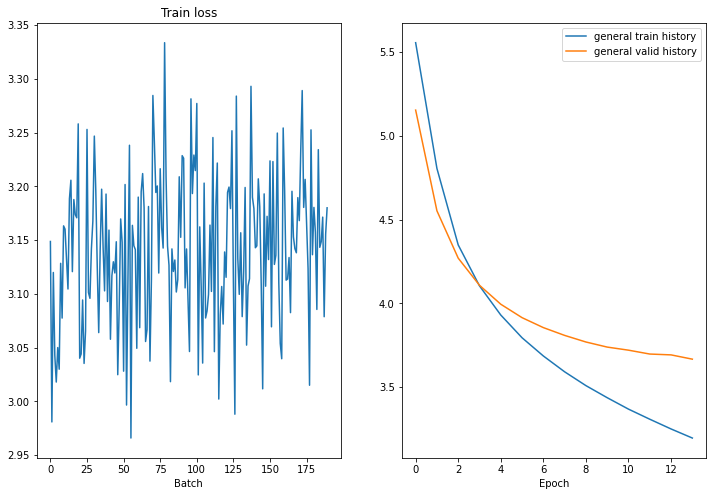

Epoch: 15 | Time: 2m 41s
	Train Loss: 3.141 | Train PPL:  23.126
	 Val. Loss: 3.669 |  Val. PPL:  39.216


In [50]:
#TF train
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1
TF=1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    if epoch > 2 and valid_history[-2] < valid_history[-1] :
        if optimizer.param_groups[0]['lr'] > 1e-6:
            optimizer.param_groups[0]['lr'] /= 10
        else:
            print(f"Early stop at {epoch} epoch!")
            break

    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

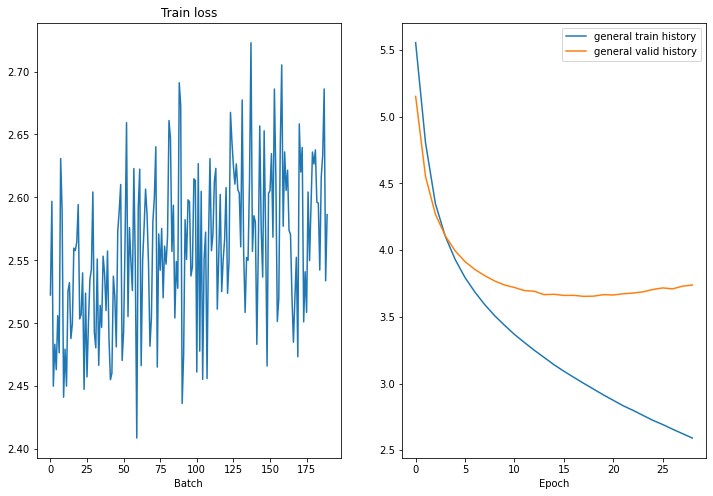

Epoch: 15 | Time: 2m 40s
	Train Loss: 2.560 | Train PPL:  12.939
	 Val. Loss: 3.749 |  Val. PPL:  42.481


In [51]:
for epoch in range(N_EPOCHS):
        
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [67]:
torch.save(network.state_dict(), 'flickr_30epoch.pt')

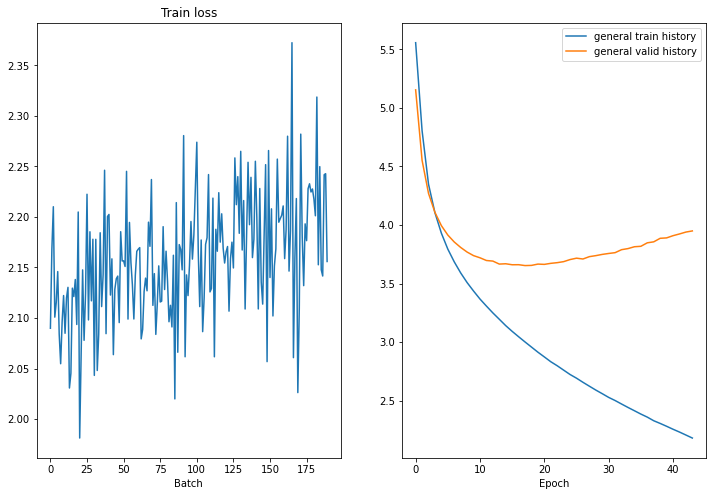

Epoch: 15 | Time: 2m 39s
	Train Loss: 2.161 | Train PPL:   8.678
	 Val. Loss: 3.961 |  Val. PPL:  52.535


In [68]:
for epoch in range(N_EPOCHS):
        
    start_time = time.time()
    
    train_loss = train(network, train_loader, optimizer, CLIP, TF, train_history, valid_history)
    valid_loss = evaluate(network, val_loader)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
           
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(network.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [52]:
@torch.no_grad()
def generate_caption(image, model, vocabulary, t=1,
                     sample=True, max_len=100, mode='distrib'):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    model.eval()
    vocab = vocabulary.get_itos() 
    input = torch.ones(1,1,dtype=torch.int).to(device)
    result = []
    h,c = None, None
    img = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
    if mode == 'distrib':
        for _ in range(max_len):
            logit, h, c = model(img, input, h, c, TF=0)
            probs = torch.softmax(logit[0,0]/t, dim=-1)            
            distribution = Categorical(probs)
            sampled = distribution.sample()
            result.append(vocab[sampled.item()])
            if result[-1] == '<eos>':
                break 
            input = torch.tensor([[sampled.item()]]).to(device)
    if mode == 'greedy':
        for _ in range(max_len):
            logit, h, c = model(img, input, h, c, TF=0)
            input = logit.argmax(-1)
            result.append(vocab[input.item()])
            if result[-1] == '<eos>':
                break                               
    return result

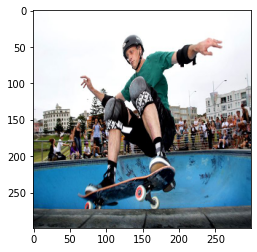

In [69]:
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

#sample image
!wget --quiet -O  img.jpg https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
plt.imshow(img)

In [70]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

People are jumping in the air over a body of water


In [71]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

People are jumping on a rail in the middle of a body of water
People are in a skate park
Boy wearing a black shirt and hat is jumping over a ramp
People are skateboarding on a bridge
People are jumping in the water


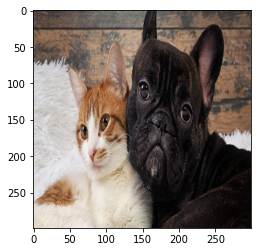

In [72]:
!wget --quiet -O  img.jpg http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255
plt.imshow(img)
plt.show()

In [73]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

Young boy is looking at a small child


In [74]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

Black and tan dog is standing next to each other
Young boy with brown hair is standing next to a small tree
White dog is standing in the sand
Man is sitting in a chair in a library
White dog with a black collar is looking at the camera


In [ ]:
!wget --quiet -O  img.jpg https://kidsdiscover.com/wp-content/uploads/2013/11/x.jpg
img = plt.imread('img.jpg')
img =  cv2.resize(src=img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC).astype('float32') / 255

plt.imshow(img)
plt.show()

In [64]:
print(' '.join(generate_caption(img, network, vocabulary, mode='greedy')[:-1]).capitalize())

Young girl is holding a red ball in the background


In [65]:
for _ in range(5):
    print(' '.join(generate_caption(img, network, vocabulary, t=0.5)[:-1]).capitalize())

Young girl wearing a pink coat is playing on a red chair in front
Young girl is playing in a snow covered area
In white shirt with a white plastic alligator
Young child is looking at the camera
Girl is holding a red and white plastic bag
